### Temperature modelling

In [2]:
import torch

In [3]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0] # temp in celsius
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # unknown units

t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [4]:
import matplotlib.pyplot as plt

If we plot the datapoints, a clear pattern can be seen.

Text(0, 0.5, 'Temperature (celsius)')

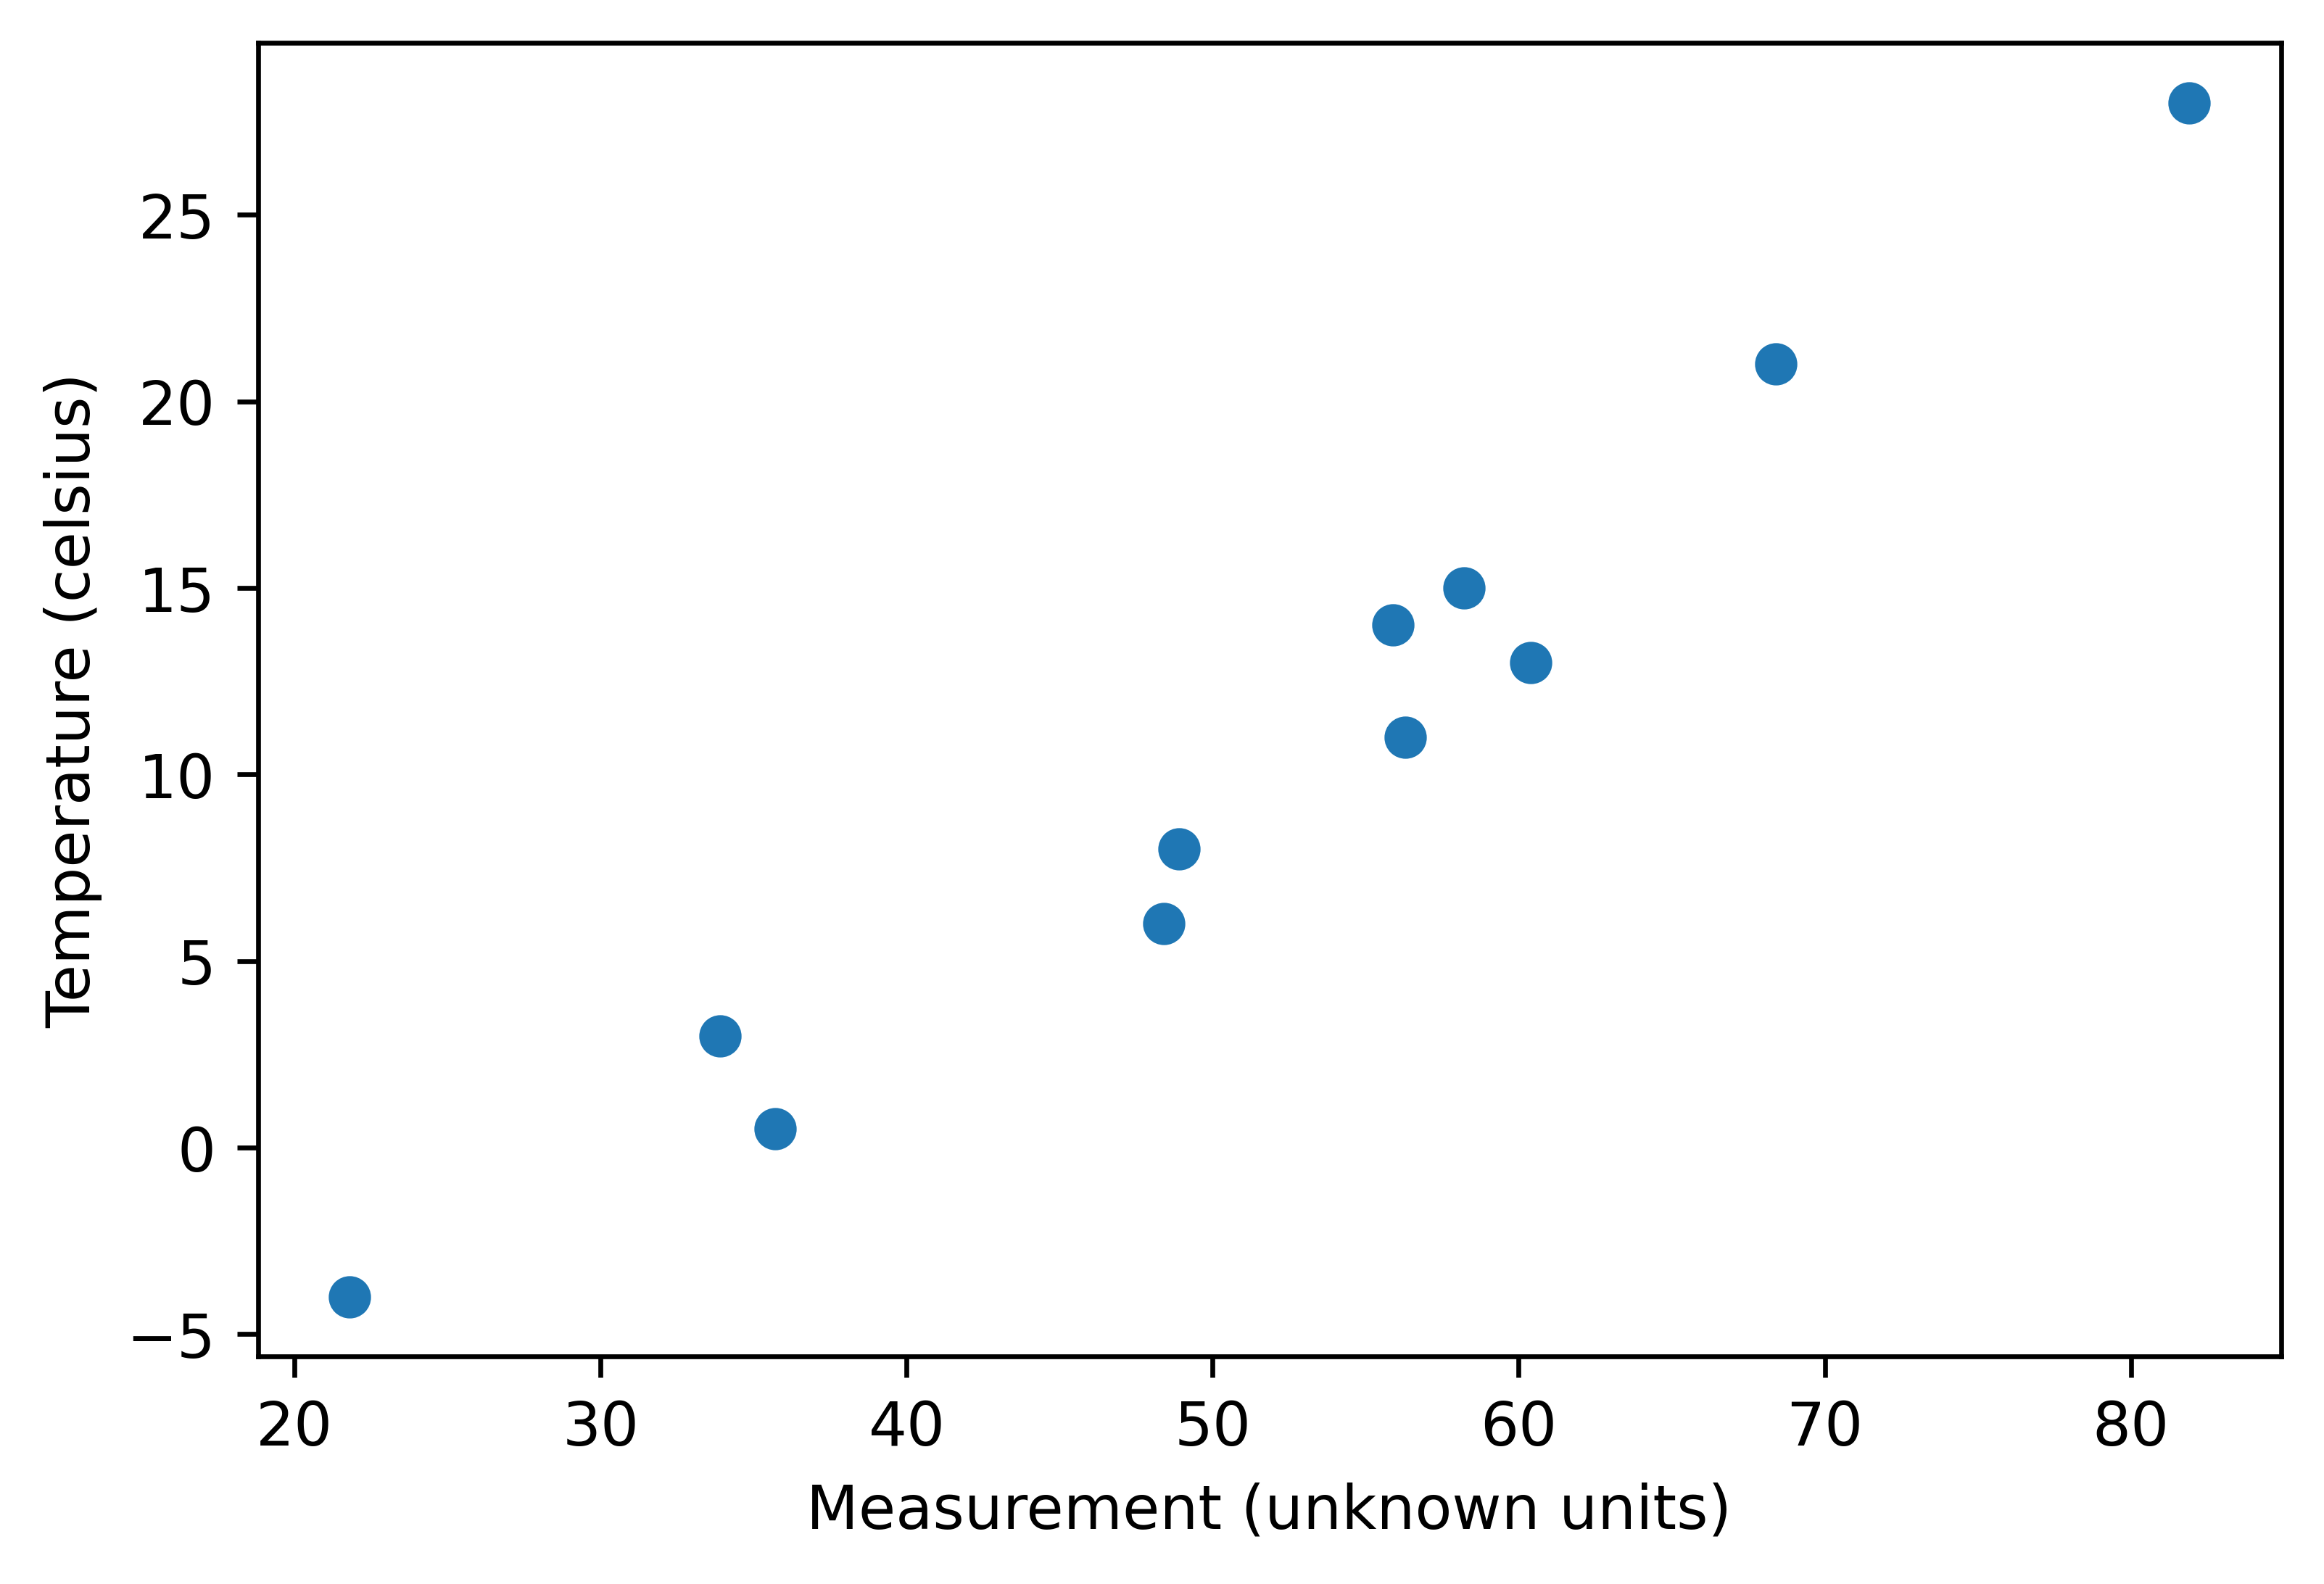

In [5]:
fig = plt.figure(dpi=600)
plt.scatter(t_u.numpy(), t_c.numpy())
plt.xlabel("Measurement (unknown units)")
plt.ylabel("Temperature (celsius)")

#### Approach 1: Linear model

In [6]:
# Our two variables might be linearly related.
# Multiplying t_u by a factor and adding a constant may provide the temperature in celsius
# e.g. t_c = w * t_u + b where t_c is our actual (ground truth) temperature value

def model(t_u, w, b):
    
    """
    t_u = input tensor
    w = weight parameter
    b = bias parameter
    """
    
    return w * t_u + b

def loss_fn(t_p, t_c):
    
    """
    mean squared error
    """
    
    squared_diffs = (t_p - t_c) **2
    return squared_diffs.mean()

In [7]:
# Can now initialise parameters and invoke the model

w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [8]:
# And check loss value

loss = loss_fn(t_p, t_c)
loss

tensor(1763.8846)

How do we estimate w and b such that the loss reaches a minimum? Using gradient descent.

In [10]:
"""
In the neighbourhood of the current values of w and b, a unit increase in w leads to some change in the loss.
If the change is negative, we increase w to minimize loss.
If the change is positive, w is decreased.
Both should be propotional to the rate of change of the loss.

It's wise for the rate of change in parameter values to be gradual, which is controllable using a scaling
factor called the learning rate.
"""

# Protip: prepended hyperparams with h_
h_delta = 0.1
h_learning_rate = 1e-2

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + h_delta, b), t_c) - 
    loss_fn(model(t_u, w - h_delta, b), t_c)) / (2.0 * h_delta)

w = w -  h_learning_rate * loss_rate_of_change_w

loss_rate_of_change_b = \
    (loss_fn(model(t_u,  + h_delta, b), t_c) - 
    loss_fn(model(t_u, w - h_delta, b), t_c)) / (2.0 * h_delta)

b = b - h_learning_rate * loss_rate_of_change_b

In [11]:
# For a model of many (2 - n) parameters, delta becomes the derivitive of the loss with respect to each
# parameter - the collection of which is our "gradients"

def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs
    
def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

In [12]:
def grad_fn(t_u, t_c, t_p, w, b):
    """
    The function returning the gradient of the loss with respect
    to w and b
    """
    dloss_dtp = dloss_fn(t_p, t_c)
    print(f"dloss_dtp: {dloss_dtp}")
    print(f"dmodel_dw(t-u, w, b): {dmodel_dw(t_u, w, b)}")
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)

    # Summation is the reverse of broadcast which occurs when applying the
    # parameters to an entire vector of inputs in the model
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

#### Training loop

In [13]:
def training_loop(n_epochs, h_learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs+1):
        w, b = params
        
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)
        
        params = params - h_learning_rate * grad
        
        print("Epoch %d, Loss %f" % (epoch, float(loss)))
    
    return params

In [14]:
training_loop(
    n_epochs = 100,
    h_learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c
)

dloss_dtp: tensor([6.4000, 7.6182, 7.8545, 9.8000, 8.2364, 7.4364, 5.6182, 4.6909, 7.7091,
        8.6182, 8.6182])
dmodel_dw(t-u, w, b): tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])
Epoch 1, Loss 1763.884644
dloss_dtp: tensor([-286.9638, -451.6536, -470.3077, -663.0167, -454.3207, -394.3426,
        -272.9618, -174.5085, -389.9632, -487.6133, -553.3194])
dmodel_dw(t-u, w, b): tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])
Epoch 2, Loss 5802485.500000
dloss_dtp: tensor([16679.3809, 26109.9629, 27183.8418, 38248.9531, 26297.3008, 22842.1797,
        15838.3594, 10189.1475, 22609.0547, 28211.5645, 31945.9668])
dmodel_dw(t-u, w, b): tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])
Epoch 3, Loss 19408035840.000000
dloss_dtp: tensor([ -964555.8125, -1510060.1250, -1572171.8750, -2212193.

tensor([nan, nan])

Gradient explosion has occurred. Some losses became inf.

`params` is receiving updates which are too large, so we are overshooting the minimum due to overcorrection. This leads to *divergence*.

In [15]:
# The quick answer is to use a smaller learning rate.
# Normally we change leraning rates by orders of magnitude, so 1e-3 or 1e-4

training_loop(
    n_epochs = 100,
    h_learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c
)

dloss_dtp: tensor([6.4000, 7.6182, 7.8545, 9.8000, 8.2364, 7.4364, 5.6182, 4.6909, 7.7091,
        8.6182, 8.6182])
dmodel_dw(t-u, w, b): tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])
Epoch 1, Loss 1763.884644
dloss_dtp: tensor([3.4664, 3.0255, 3.0729, 3.0718, 3.6108, 3.4186, 2.8324, 2.8989, 3.7324,
        3.6559, 2.9988])
dmodel_dw(t-u, w, b): tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])
Epoch 2, Loss 323.090546
dloss_dtp: tensor([2.2587, 1.1348, 1.1045, 0.3021, 1.7066, 1.7646, 1.6856, 2.1612, 2.0953,
        1.6131, 0.6856])
dmodel_dw(t-u, w, b): tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])
Epoch 3, Loss 78.929634
dloss_dtp: tensor([ 1.7615,  0.3565,  0.2942, -0.8380,  0.9228,  1.0837,  1.2135,  1.8575,
         1.4214,  0.7722, -0.2667])
dmodel_dw(t-u, w, b): tensor([35.700

tensor([ 0.2327, -0.0438])

New problem: updates to parameters are very small and eventually stall. The best course of action is to make the learning rate *adaptive* according to the magnitude of updates.

This can be done using an optimizer.

### Normalizing inputs

Weight and bias currently live in differently scaled spaces. 

The fix is to change the inputs so that gradients aren't so different.

This can be done with normalization of input values to within range of -1.0 to 1.0

In [16]:
t_un = 0.1 * t_u # works for this case

In [17]:
# Compare the gradients here to those of epoch 1 in previous training loops
# Gradients are now of a similar magnitude, so using a single learning rate for both parameters works fine.
training_loop(
    n_epochs = 100,
    h_learning_rate = 1e-2, # Return back from 1e-2
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un, # Use normalized
    t_c = t_c
)

dloss_dtp: tensor([ 0.5582, -1.5291, -1.6691, -3.6018, -0.9764, -0.5655,  0.0709,  1.1236,
        -0.2109, -1.2655, -2.5745])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1, Loss 80.364342
dloss_dtp: tensor([ 1.0813, -0.7209, -0.8284, -2.4267, -0.1625,  0.1440,  0.5686,  1.4506,
         0.4914, -0.3938, -1.5900])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2, Loss 37.574917
dloss_dtp: tensor([ 1.2860, -0.4029, -0.4975, -1.9628,  0.1577,  0.4227,  0.7632,  1.5773,
         0.7674, -0.0505, -1.2018])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3, Loss 30.871077
dloss_dtp: tensor([ 1.3653, -0.2778, -0.3672, -1.7788,  0.2837,  0.5319,  0.8385,  1.6251,
         0.8755,  0.0848, -1.0484])
dmodel_dw(t-u, w, b): tensor([3.5700, 5

tensor([ 2.7553, -2.5162])

In [18]:
# Changes in params gets smaller over time along the direction of gradient descent, as loss decreases.
# This can be seen if we drastically increase the number of epochs

params = training_loop(
    n_epochs = 5000,
    h_learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c
)

dloss_dtp: tensor([ 0.5582, -1.5291, -1.6691, -3.6018, -0.9764, -0.5655,  0.0709,  1.1236,
        -0.2109, -1.2655, -2.5745])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1, Loss 80.364342
dloss_dtp: tensor([ 1.0813, -0.7209, -0.8284, -2.4267, -0.1625,  0.1440,  0.5686,  1.4506,
         0.4914, -0.3938, -1.5900])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2, Loss 37.574917
dloss_dtp: tensor([ 1.2860, -0.4029, -0.4975, -1.9628,  0.1577,  0.4227,  0.7632,  1.5773,
         0.7674, -0.0505, -1.2018])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3, Loss 30.871077
dloss_dtp: tensor([ 1.3653, -0.2778, -0.3672, -1.7788,  0.2837,  0.5319,  0.8385,  1.6251,
         0.8755,  0.0848, -1.0484])
dmodel_dw(t-u, w, b): tensor([3.5700, 5

Epoch 164, Loss 18.389570
dloss_dtp: tensor([ 1.1376, -0.2061, -0.2614, -1.3217,  0.3614,  0.4999,  0.5841,  1.1914,
         0.8360,  0.2232, -0.7914])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 165, Loss 18.337080
dloss_dtp: tensor([ 1.1361, -0.2061, -0.2613, -1.3199,  0.3614,  0.4993,  0.5825,  1.1889,
         0.8354,  0.2235, -0.7905])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 166, Loss 18.284777
dloss_dtp: tensor([ 1.1346, -0.2062, -0.2612, -1.3180,  0.3614,  0.4988,  0.5808,  1.1864,
         0.8349,  0.2238, -0.7897])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 167, Loss 18.232643
dloss_dtp: tensor([ 1.1331, -0.2062, -0.2610, -1.3162,  0.3613,  0.4982,  0.5792,  1.1839,
         0.8343,  0.2241, -0.7888])
dmodel_

dloss_dtp: tensor([ 0.9255, -0.2132, -0.2452, -1.0651,  0.3583,  0.4217,  0.3537,  0.8382,
         0.7528,  0.2617, -0.6717])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 325, Loss 11.871029
dloss_dtp: tensor([ 0.9243, -0.2133, -0.2451, -1.0637,  0.3583,  0.4213,  0.3524,  0.8363,
         0.7523,  0.2619, -0.6711])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 326, Loss 11.840671
dloss_dtp: tensor([ 0.9232, -0.2133, -0.2451, -1.0623,  0.3582,  0.4208,  0.3512,  0.8344,
         0.7519,  0.2621, -0.6704])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 327, Loss 11.810413
dloss_dtp: tensor([ 0.9220, -0.2134, -0.2450, -1.0609,  0.3582,  0.4204,  0.3499,  0.8325,
         0.7514,  0.2623, -0.6698])
dmodel_dw(t-u, w, b): tensor([3.5

dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 488, Loss 8.065548
dloss_dtp: tensor([ 0.7604, -0.2188, -0.2327, -0.8653,  0.3558,  0.3608,  0.1743,  0.5633,
         0.6879,  0.2917, -0.5786])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 489, Loss 8.048104
dloss_dtp: tensor([ 0.7595, -0.2189, -0.2326, -0.8643,  0.3558,  0.3605,  0.1734,  0.5619,
         0.6876,  0.2918, -0.5781])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 490, Loss 8.030723
dloss_dtp: tensor([ 0.7586, -0.2189, -0.2325, -0.8632,  0.3558,  0.3602,  0.1725,  0.5604,
         0.6872,  0.2920, -0.5776])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 491, Loss 8.013400
dloss_dtp: 

dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 650, Loss 5.889384
dloss_dtp: tensor([ 0.6367, -0.2230, -0.2233, -0.7158,  0.3540,  0.3152,  0.0401,  0.3575,
         0.6394,  0.3141, -0.5089])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 651, Loss 5.879326
dloss_dtp: tensor([ 0.6361, -0.2230, -0.2232, -0.7150,  0.3540,  0.3150,  0.0394,  0.3564,
         0.6391,  0.3142, -0.5085])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 652, Loss 5.869310
dloss_dtp: tensor([ 0.6354, -0.2231, -0.2232, -0.7142,  0.3540,  0.3148,  0.0387,  0.3553,
         0.6389,  0.3143, -0.5081])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 653, Loss 5.859322
dloss_dtp: 

Epoch 813, Loss 4.629142
dloss_dtp: tensor([ 0.5424, -0.2262, -0.2161, -0.6016,  0.3526,  0.2805, -0.0624,  0.2004,
         0.6024,  0.3312, -0.4557])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 814, Loss 4.623368
dloss_dtp: tensor([ 0.5419, -0.2262, -0.2160, -0.6010,  0.3526,  0.2803, -0.0629,  0.1996,
         0.6022,  0.3313, -0.4554])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 815, Loss 4.617611
dloss_dtp: tensor([ 0.5414, -0.2263, -0.2160, -0.6004,  0.3526,  0.2801, -0.0635,  0.1988,
         0.6020,  0.3314, -0.4551])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 816, Loss 4.611873
dloss_dtp: tensor([ 0.5409, -0.2263, -0.2160, -0.5998,  0.3526,  0.2799, -0.0640,  0.1979,
         0.6018,  0.3315, -0.4548])
dmodel_dw(t

dloss_dtp: tensor([ 0.4712, -0.2286, -0.2107, -0.5156,  0.3516,  0.2542, -0.1397,  0.0820,
         0.5744,  0.3441, -0.4155])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 976, Loss 3.905144
dloss_dtp: tensor([ 0.4709, -0.2286, -0.2106, -0.5151,  0.3516,  0.2541, -0.1401,  0.0814,
         0.5743,  0.3442, -0.4153])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 977, Loss 3.901824
dloss_dtp: tensor([ 0.4705, -0.2287, -0.2106, -0.5147,  0.3516,  0.2539, -0.1405,  0.0807,
         0.5741,  0.3442, -0.4151])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 978, Loss 3.898517
dloss_dtp: tensor([ 0.4701, -0.2287, -0.2106, -0.5142,  0.3516,  0.2538, -0.1409,  0.0801,
         0.5740,  0.3443, -0.4149])
dmodel_dw(t-u, w, b): tensor([3.5700

dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1139, Loss 3.489213
dloss_dtp: tensor([ 0.4167, -0.2305, -0.2065, -0.4496,  0.3508,  0.2341, -0.1989, -0.0089,
         0.5530,  0.3540, -0.3848])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1140, Loss 3.487308
dloss_dtp: tensor([ 0.4164, -0.2305, -0.2065, -0.4492,  0.3508,  0.2340, -0.1993, -0.0094,
         0.5529,  0.3540, -0.3846])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1141, Loss 3.485410
dloss_dtp: tensor([ 0.4161, -0.2305, -0.2065, -0.4489,  0.3508,  0.2339, -0.1996, -0.0098,
         0.5528,  0.3541, -0.3844])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1142, Loss 3.483515
dloss_d

Epoch 1305, Loss 3.246989
dloss_dtp: tensor([ 0.3749, -0.2319, -0.2033, -0.3991,  0.3502,  0.2187, -0.2443, -0.0784,
         0.5366,  0.3616, -0.3612])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1306, Loss 3.245904
dloss_dtp: tensor([ 0.3747, -0.2319, -0.2033, -0.3988,  0.3502,  0.2186, -0.2445, -0.0787,
         0.5365,  0.3616, -0.3611])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1307, Loss 3.244824
dloss_dtp: tensor([ 0.3745, -0.2319, -0.2033, -0.3985,  0.3501,  0.2186, -0.2448, -0.0791,
         0.5364,  0.3616, -0.3610])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1308, Loss 3.243747
dloss_dtp: tensor([ 0.3743, -0.2319, -0.2033, -0.3983,  0.3501,  0.2185, -0.2450, -0.0795,
         0.5364,  0.3617, -0.3608])
dmodel_

Epoch 1468, Loss 3.111103
dloss_dtp: tensor([ 0.3439, -0.2329, -0.2010, -0.3616,  0.3497,  0.2073, -0.2779, -0.1300,
         0.5244,  0.3672, -0.3437])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1469, Loss 3.110484
dloss_dtp: tensor([ 0.3438, -0.2329, -0.2009, -0.3614,  0.3497,  0.2072, -0.2781, -0.1302,
         0.5244,  0.3672, -0.3436])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1470, Loss 3.109860
dloss_dtp: tensor([ 0.3436, -0.2329, -0.2009, -0.3612,  0.3497,  0.2072, -0.2783, -0.1305,
         0.5243,  0.3672, -0.3435])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1471, Loss 3.109242
dloss_dtp: tensor([ 0.3434, -0.2330, -0.2009, -0.3610,  0.3497,  0.2071, -0.2785, -0.1308,
         0.5243,  0.3673, -0.3435])
dmodel_

dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1635, Loss 3.031619
dloss_dtp: tensor([ 0.3199, -0.2338, -0.1991, -0.3326,  0.3493,  0.1984, -0.3040, -0.1699,
         0.5150,  0.3715, -0.3302])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1636, Loss 3.031265
dloss_dtp: tensor([ 0.3198, -0.2338, -0.1991, -0.3324,  0.3493,  0.1984, -0.3041, -0.1701,
         0.5150,  0.3715, -0.3301])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1637, Loss 3.030913
dloss_dtp: tensor([ 0.3197, -0.2338, -0.1991, -0.3323,  0.3493,  0.1984, -0.3043, -0.1703,
         0.5149,  0.3716, -0.3301])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1638, Loss 3.030564
dloss_d

dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1801, Loss 2.986771
dloss_dtp: tensor([ 0.3020, -0.2344, -0.1978, -0.3108,  0.3491,  0.1918, -0.3235, -0.1998,
         0.5080,  0.3748, -0.3201])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1802, Loss 2.986570
dloss_dtp: tensor([ 0.3019, -0.2344, -0.1978, -0.3107,  0.3491,  0.1918, -0.3236, -0.1999,
         0.5079,  0.3748, -0.3200])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1803, Loss 2.986371
dloss_dtp: tensor([ 0.3018, -0.2344, -0.1978, -0.3106,  0.3491,  0.1918, -0.3237, -0.2001,
         0.5079,  0.3748, -0.3200])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1804, Loss 2.986171
dloss_d

dloss_dtp: tensor([ 0.2887, -0.2348, -0.1968, -0.2947,  0.3489,  0.1869, -0.3380, -0.2220,
         0.5027,  0.3772, -0.3126])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1965, Loss 2.961497
dloss_dtp: tensor([ 0.2886, -0.2348, -0.1967, -0.2946,  0.3489,  0.1869, -0.3380, -0.2221,
         0.5027,  0.3772, -0.3125])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1966, Loss 2.961382
dloss_dtp: tensor([ 0.2885, -0.2348, -0.1967, -0.2945,  0.3489,  0.1869, -0.3381, -0.2222,
         0.5027,  0.3772, -0.3125])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 1967, Loss 2.961268
dloss_dtp: tensor([ 0.2884, -0.2348, -0.1967, -0.2945,  0.3489,  0.1868, -0.3382, -0.2223,
         0.5027,  0.3772, -0.3124])
dmodel_dw(t-u, w, b): tensor([3.5

dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2127, Loss 2.947158
dloss_dtp: tensor([ 0.2785, -0.2352, -0.1960, -0.2825,  0.3487,  0.1832, -0.3489, -0.2388,
         0.4988,  0.3790, -0.3069])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2128, Loss 2.947091
dloss_dtp: tensor([ 0.2785, -0.2352, -0.1960, -0.2824,  0.3487,  0.1832, -0.3490, -0.2389,
         0.4988,  0.3790, -0.3068])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2129, Loss 2.947026
dloss_dtp: tensor([ 0.2784, -0.2352, -0.1960, -0.2824,  0.3487,  0.1831, -0.3491, -0.2390,
         0.4987,  0.3791, -0.3068])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2130, Loss 2.946960
dloss_d

dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2288, Loss 2.938933
dloss_dtp: tensor([ 0.2710, -0.2354, -0.1954, -0.2733,  0.3486,  0.1804, -0.3572, -0.2514,
         0.4958,  0.3804, -0.3026])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2289, Loss 2.938893
dloss_dtp: tensor([ 0.2709, -0.2354, -0.1954, -0.2733,  0.3486,  0.1804, -0.3572, -0.2515,
         0.4958,  0.3804, -0.3026])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2290, Loss 2.938857
dloss_dtp: tensor([ 0.2709, -0.2354, -0.1954, -0.2732,  0.3486,  0.1804, -0.3573, -0.2516,
         0.4958,  0.3804, -0.3025])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2291, Loss 2.938820
dloss_d

Epoch 2449, Loss 2.934175
dloss_dtp: tensor([ 0.2652, -0.2356, -0.1950, -0.2664,  0.3485,  0.1783, -0.3634, -0.2610,
         0.4935,  0.3815, -0.2993])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2450, Loss 2.934151
dloss_dtp: tensor([ 0.2652, -0.2356, -0.1950, -0.2663,  0.3485,  0.1783, -0.3635, -0.2611,
         0.4935,  0.3815, -0.2993])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2451, Loss 2.934129
dloss_dtp: tensor([ 0.2651, -0.2356, -0.1950, -0.2663,  0.3485,  0.1782, -0.3635, -0.2611,
         0.4935,  0.3815, -0.2993])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2452, Loss 2.934108
dloss_dtp: tensor([ 0.2651, -0.2356, -0.1950, -0.2662,  0.3485,  0.1782, -0.3635, -0.2612,
         0.4935,  0.3815, -0.2993])
dmodel_

dloss_dtp: tensor([ 0.2608, -0.2358, -0.1946, -0.2610,  0.3485,  0.1767, -0.3682, -0.2683,
         0.4918,  0.3822, -0.2969])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2611, Loss 2.931411
dloss_dtp: tensor([ 0.2608, -0.2358, -0.1946, -0.2610,  0.3485,  0.1766, -0.3682, -0.2683,
         0.4918,  0.3823, -0.2969])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2612, Loss 2.931398
dloss_dtp: tensor([ 0.2608, -0.2358, -0.1946, -0.2610,  0.3485,  0.1766, -0.3682, -0.2684,
         0.4918,  0.3823, -0.2968])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2613, Loss 2.931384
dloss_dtp: tensor([ 0.2608, -0.2358, -0.1946, -0.2610,  0.3485,  0.1766, -0.3683, -0.2684,
         0.4918,  0.3823, -0.2968])
dmodel_dw(t-u, w, b): tensor([3.5

dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2771, Loss 2.929830
dloss_dtp: tensor([ 0.2575, -0.2359, -0.1944, -0.2570,  0.3484,  0.1754, -0.3718, -0.2739,
         0.4905,  0.3829, -0.2950])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2772, Loss 2.929822
dloss_dtp: tensor([ 0.2575, -0.2359, -0.1944, -0.2570,  0.3484,  0.1754, -0.3718, -0.2739,
         0.4905,  0.3829, -0.2950])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2773, Loss 2.929816
dloss_dtp: tensor([ 0.2575, -0.2359, -0.1944, -0.2570,  0.3484,  0.1754, -0.3719, -0.2739,
         0.4905,  0.3829, -0.2950])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2774, Loss 2.929806
dloss_d

dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2932, Loss 2.928909
dloss_dtp: tensor([ 0.2550, -0.2360, -0.1942, -0.2540,  0.3484,  0.1745, -0.3746, -0.2781,
         0.4895,  0.3833, -0.2936])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2933, Loss 2.928904
dloss_dtp: tensor([ 0.2549, -0.2360, -0.1942, -0.2539,  0.3484,  0.1745, -0.3746, -0.2781,
         0.4895,  0.3833, -0.2935])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2934, Loss 2.928902
dloss_dtp: tensor([ 0.2549, -0.2360, -0.1942, -0.2539,  0.3484,  0.1745, -0.3746, -0.2781,
         0.4895,  0.3833, -0.2935])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 2935, Loss 2.928897
dloss_d

Epoch 3093, Loss 2.928378
dloss_dtp: tensor([ 0.2530, -0.2360, -0.1940, -0.2516,  0.3484,  0.1738, -0.3767, -0.2813,
         0.4888,  0.3837, -0.2925])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3094, Loss 2.928375
dloss_dtp: tensor([ 0.2530, -0.2360, -0.1940, -0.2516,  0.3484,  0.1738, -0.3767, -0.2813,
         0.4888,  0.3837, -0.2925])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3095, Loss 2.928372
dloss_dtp: tensor([ 0.2530, -0.2360, -0.1940, -0.2516,  0.3484,  0.1738, -0.3767, -0.2813,
         0.4888,  0.3837, -0.2925])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3096, Loss 2.928370
dloss_dtp: tensor([ 0.2530, -0.2360, -0.1940, -0.2516,  0.3484,  0.1738, -0.3767, -0.2813,
         0.4888,  0.3837, -0.2925])
dmodel_

dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3256, Loss 2.928066
dloss_dtp: tensor([ 0.2515, -0.2361, -0.1939, -0.2498,  0.3483,  0.1732, -0.3783, -0.2838,
         0.4882,  0.3839, -0.2916])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3257, Loss 2.928065
dloss_dtp: tensor([ 0.2515, -0.2361, -0.1939, -0.2498,  0.3483,  0.1732, -0.3783, -0.2838,
         0.4882,  0.3839, -0.2916])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3258, Loss 2.928063
dloss_dtp: tensor([ 0.2515, -0.2361, -0.1939, -0.2498,  0.3483,  0.1732, -0.3783, -0.2838,
         0.4882,  0.3839, -0.2916])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3259, Loss 2.928061
dloss_d

dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3419, Loss 2.927888
dloss_dtp: tensor([ 0.2504, -0.2361, -0.1938, -0.2485,  0.3483,  0.1728, -0.3795, -0.2856,
         0.4877,  0.3841, -0.2910])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3420, Loss 2.927886
dloss_dtp: tensor([ 0.2504, -0.2361, -0.1938, -0.2485,  0.3483,  0.1728, -0.3795, -0.2856,
         0.4877,  0.3841, -0.2910])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3421, Loss 2.927887
dloss_dtp: tensor([ 0.2504, -0.2361, -0.1938, -0.2485,  0.3483,  0.1728, -0.3795, -0.2856,
         0.4877,  0.3841, -0.2910])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3422, Loss 2.927885
dloss_d

dloss_dtp: tensor([ 0.2496, -0.2361, -0.1938, -0.2474,  0.3483,  0.1725, -0.3804, -0.2871,
         0.4874,  0.3843, -0.2905])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3585, Loss 2.927783
dloss_dtp: tensor([ 0.2496, -0.2361, -0.1938, -0.2474,  0.3483,  0.1725, -0.3804, -0.2871,
         0.4874,  0.3843, -0.2905])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3586, Loss 2.927783
dloss_dtp: tensor([ 0.2496, -0.2361, -0.1938, -0.2474,  0.3483,  0.1725, -0.3804, -0.2871,
         0.4874,  0.3843, -0.2905])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3587, Loss 2.927781
dloss_dtp: tensor([ 0.2495, -0.2361, -0.1938, -0.2474,  0.3483,  0.1725, -0.3804, -0.2871,
         0.4874,  0.3843, -0.2905])
dmodel_dw(t-u, w, b): tensor([3.5

Epoch 3751, Loss 2.927724
dloss_dtp: tensor([ 0.2489, -0.2362, -0.1937, -0.2466,  0.3483,  0.1723, -0.3811, -0.2882,
         0.4871,  0.3844, -0.2901])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3752, Loss 2.927725
dloss_dtp: tensor([ 0.2489, -0.2362, -0.1937, -0.2466,  0.3483,  0.1723, -0.3811, -0.2882,
         0.4871,  0.3844, -0.2901])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3753, Loss 2.927724
dloss_dtp: tensor([ 0.2489, -0.2362, -0.1937, -0.2466,  0.3483,  0.1723, -0.3811, -0.2882,
         0.4871,  0.3844, -0.2901])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3754, Loss 2.927724
dloss_dtp: tensor([ 0.2489, -0.2362, -0.1937, -0.2466,  0.3483,  0.1723, -0.3811, -0.2882,
         0.4871,  0.3844, -0.2901])
dmodel_

dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3886, Loss 2.927696
dloss_dtp: tensor([ 0.2485, -0.2362, -0.1937, -0.2461,  0.3483,  0.1721, -0.3816, -0.2888,
         0.4870,  0.3845, -0.2899])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3887, Loss 2.927696
dloss_dtp: tensor([ 0.2485, -0.2362, -0.1937, -0.2461,  0.3483,  0.1721, -0.3816, -0.2888,
         0.4870,  0.3845, -0.2899])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3888, Loss 2.927695
dloss_dtp: tensor([ 0.2485, -0.2362, -0.1937, -0.2461,  0.3483,  0.1721, -0.3816, -0.2888,
         0.4870,  0.3845, -0.2899])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 3889, Loss 2.927694
dloss_d

dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4023, Loss 2.927677
dloss_dtp: tensor([ 0.2482, -0.2362, -0.1937, -0.2457,  0.3483,  0.1720, -0.3819, -0.2894,
         0.4869,  0.3845, -0.2897])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4024, Loss 2.927677
dloss_dtp: tensor([ 0.2482, -0.2362, -0.1937, -0.2457,  0.3483,  0.1720, -0.3819, -0.2894,
         0.4869,  0.3845, -0.2897])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4025, Loss 2.927677
dloss_dtp: tensor([ 0.2482, -0.2362, -0.1937, -0.2457,  0.3483,  0.1720, -0.3819, -0.2894,
         0.4869,  0.3845, -0.2897])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4026, Loss 2.927676
dloss_d

dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4160, Loss 2.927666
dloss_dtp: tensor([ 0.2479, -0.2362, -0.1937, -0.2454,  0.3483,  0.1719, -0.3822, -0.2898,
         0.4868,  0.3846, -0.2896])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4161, Loss 2.927664
dloss_dtp: tensor([ 0.2479, -0.2362, -0.1937, -0.2454,  0.3483,  0.1719, -0.3822, -0.2898,
         0.4868,  0.3846, -0.2896])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4162, Loss 2.927666
dloss_dtp: tensor([ 0.2479, -0.2362, -0.1937, -0.2454,  0.3483,  0.1719, -0.3822, -0.2898,
         0.4868,  0.3846, -0.2896])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4163, Loss 2.927665
dloss_d

dloss_dtp: tensor([ 0.2477, -0.2362, -0.1936, -0.2452,  0.3483,  0.1718, -0.3824, -0.2902,
         0.4867,  0.3846, -0.2895])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4296, Loss 2.927657
dloss_dtp: tensor([ 0.2477, -0.2362, -0.1936, -0.2452,  0.3483,  0.1718, -0.3825, -0.2902,
         0.4867,  0.3846, -0.2895])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4297, Loss 2.927657
dloss_dtp: tensor([ 0.2477, -0.2362, -0.1936, -0.2452,  0.3483,  0.1718, -0.3825, -0.2902,
         0.4867,  0.3846, -0.2895])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4298, Loss 2.927657
dloss_dtp: tensor([ 0.2477, -0.2362, -0.1936, -0.2452,  0.3483,  0.1718, -0.3825, -0.2902,
         0.4867,  0.3846, -0.2895])
dmodel_dw(t-u, w, b): tensor([3.5

Epoch 4433, Loss 2.927655
dloss_dtp: tensor([ 0.2475, -0.2362, -0.1936, -0.2450,  0.3483,  0.1718, -0.3826, -0.2904,
         0.4866,  0.3847, -0.2894])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4434, Loss 2.927654
dloss_dtp: tensor([ 0.2475, -0.2362, -0.1936, -0.2450,  0.3483,  0.1718, -0.3826, -0.2904,
         0.4866,  0.3847, -0.2894])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4435, Loss 2.927655
dloss_dtp: tensor([ 0.2475, -0.2362, -0.1936, -0.2450,  0.3483,  0.1718, -0.3826, -0.2904,
         0.4866,  0.3847, -0.2894])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4436, Loss 2.927652
dloss_dtp: tensor([ 0.2475, -0.2362, -0.1936, -0.2450,  0.3483,  0.1718, -0.3826, -0.2904,
         0.4866,  0.3847, -0.2894])
dmodel_

dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4569, Loss 2.927651
dloss_dtp: tensor([ 0.2474, -0.2362, -0.1936, -0.2448,  0.3483,  0.1717, -0.3828, -0.2907,
         0.4866,  0.3847, -0.2893])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4570, Loss 2.927652
dloss_dtp: tensor([ 0.2474, -0.2362, -0.1936, -0.2448,  0.3483,  0.1717, -0.3828, -0.2907,
         0.4866,  0.3847, -0.2893])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4571, Loss 2.927650
dloss_dtp: tensor([ 0.2474, -0.2362, -0.1936, -0.2448,  0.3483,  0.1717, -0.3828, -0.2907,
         0.4866,  0.3847, -0.2893])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4572, Loss 2.927649
dloss_d

dloss_dtp: tensor([ 0.2473, -0.2362, -0.1936, -0.2447,  0.3483,  0.1717, -0.3829, -0.2908,
         0.4865,  0.3847, -0.2892])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4726, Loss 2.927650
dloss_dtp: tensor([ 0.2473, -0.2362, -0.1936, -0.2447,  0.3483,  0.1717, -0.3829, -0.2908,
         0.4865,  0.3847, -0.2892])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4727, Loss 2.927648
dloss_dtp: tensor([ 0.2473, -0.2362, -0.1936, -0.2447,  0.3483,  0.1717, -0.3829, -0.2908,
         0.4865,  0.3847, -0.2892])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4728, Loss 2.927648
dloss_dtp: tensor([ 0.2473, -0.2362, -0.1936, -0.2447,  0.3483,  0.1717, -0.3829, -0.2908,
         0.4865,  0.3847, -0.2892])
dmodel_dw(t-u, w, b): tensor([3.5

Epoch 4886, Loss 2.927649
dloss_dtp: tensor([ 0.2472, -0.2362, -0.1936, -0.2446,  0.3483,  0.1716, -0.3830, -0.2910,
         0.4865,  0.3847, -0.2892])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4887, Loss 2.927647
dloss_dtp: tensor([ 0.2472, -0.2362, -0.1936, -0.2446,  0.3483,  0.1716, -0.3830, -0.2910,
         0.4865,  0.3847, -0.2892])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4888, Loss 2.927649
dloss_dtp: tensor([ 0.2472, -0.2362, -0.1936, -0.2446,  0.3483,  0.1716, -0.3830, -0.2910,
         0.4865,  0.3847, -0.2892])
dmodel_dw(t-u, w, b): tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])
Epoch 4889, Loss 2.927648
dloss_dtp: tensor([ 0.2472, -0.2362, -0.1936, -0.2446,  0.3483,  0.1716, -0.3830, -0.2910,
         0.4865,  0.3847, -0.2892])
dmodel_

Notice that the values for w and b look like those we'd normally use to convert celcius to fahrenheit (which would be w=5.5556 and b=-17.7778). 

This reveals what our input x values are, and that the gradient descent process is working.

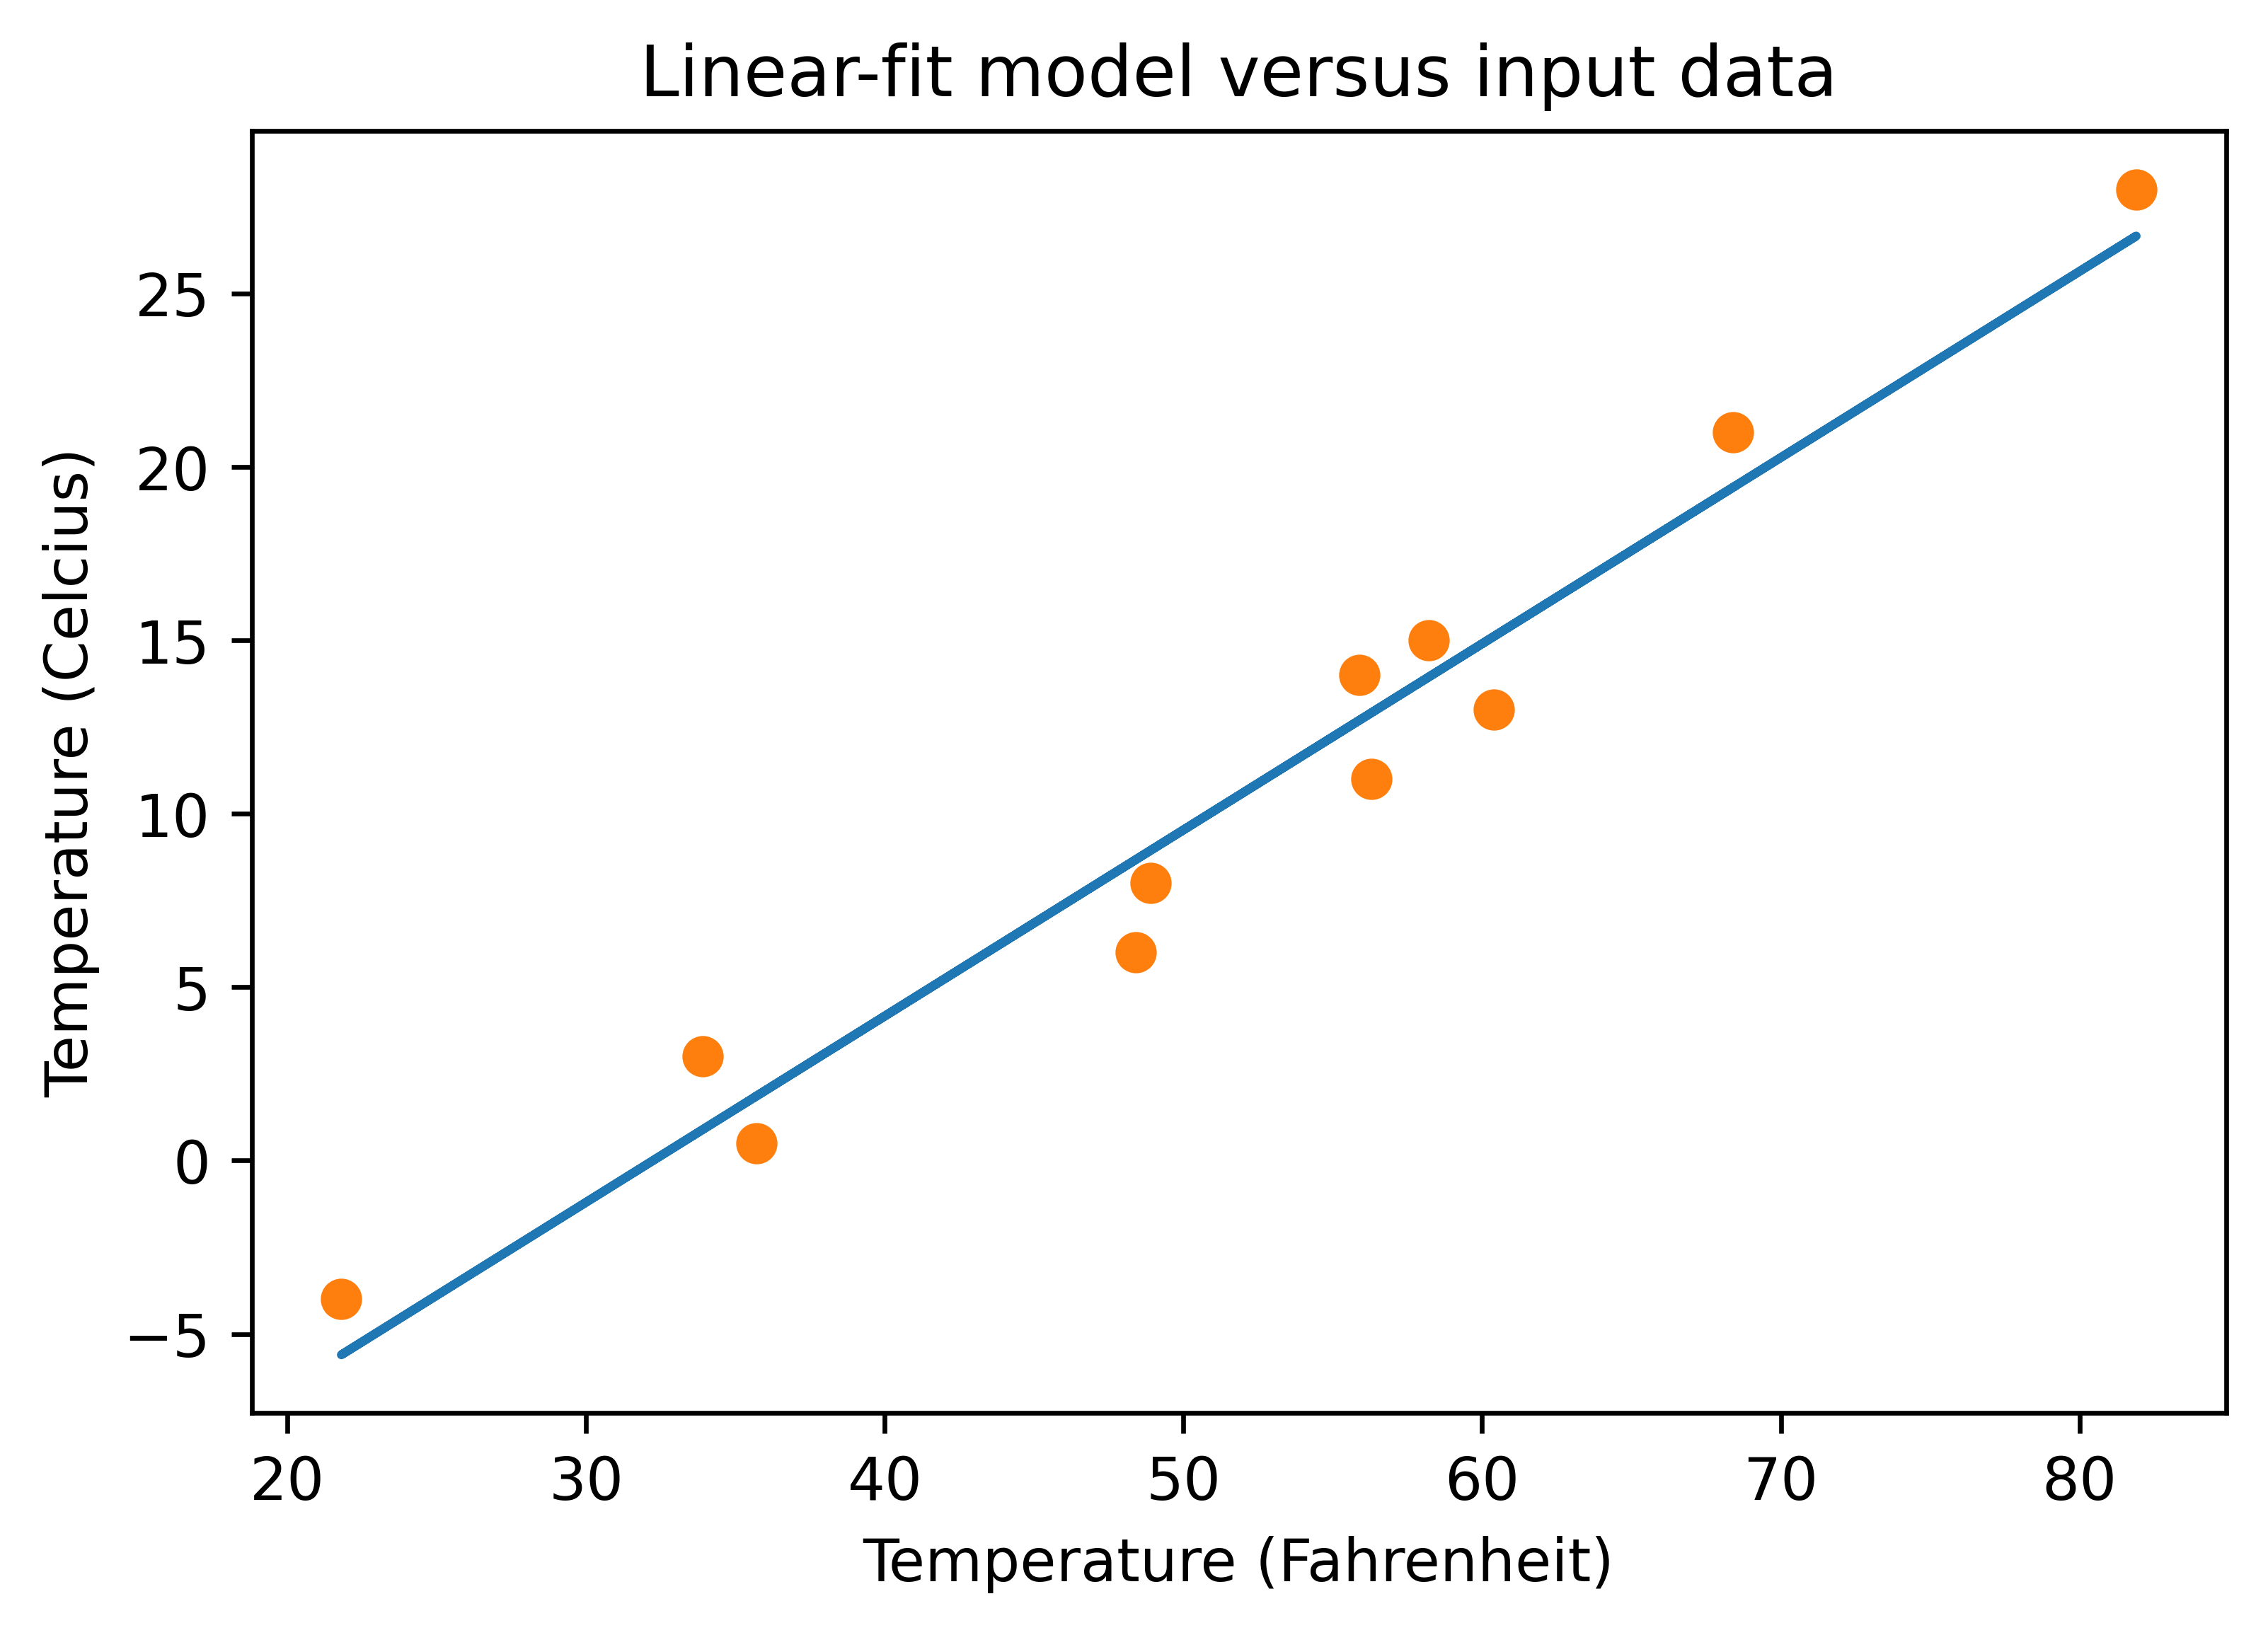

In [19]:
t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.title("Linear-fit model versus input data")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Temperature (Celcius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

## PyTorch's autograd

Autograd is a component of tensors, which enables them to automatically provide the chain of derivatives of the operations which created them with respect to their inputs.

Given a forward expression, no matter how nested, PyTorch will automatically provide the gradient of that expression with respect to its input parameters.


#### Rewriting temperature estimation code with autograd

In [20]:
# requires_grad=True tells PyTorch to track the entire fmailyu tree of tensors resulting from operations on `params`.

params = torch.tensor([1.0, 0.0], requires_grad=True)

# Any tensor that will have params as an ancestor will have access to the chain of functions that
# were called to get from params to that tensor

# In casae these functions differentiable, the value of the derivative will be automatically populated as a grad
# attribute of the params tensor (see below)

In [21]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad # The derivatices of the loss with respect to each element of `params`.

tensor([4517.2969,   82.6000])

NOTE: calling `backward()` leads derivatives to *accumulate* at leaf nodes.

If backward was called earlier, loss is evaluated again, then backward is called again (as in any training loop), gradients computed for a new iteration will be of incorrect value.

Thus **gradients must be zeroed explicitly at each iteration**. This is necessary because this may not always be something we want for more complex models.

In [25]:
# Update to the prior code with gradient zero-ing per iteration (epoch)

def training_loop(n_epochs, h_learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs+1):
        if params.grad is not None:
            params.grad.zero_()
            
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():
            params -= h_learning_rate * params.grad
            
        if epoch % 500 == 0:
            print("Epoch %d, Loss %f" % (epoch, float(loss)))
            
    return params

In [28]:
training_loop(
    n_epochs = 5000,
    h_learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_un,
    t_c = t_c
)

NameError: name 'learning_rate' is not defined